In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os, torch, pickle
from jarvis.utils import tqdm
from hexarena import DATA_DIR, STORE_DIR

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng()

# Gather precomputed belief results

In [2]:
from hexarena.utils import load_monkey_data, align_monkey_data
from hexarena.scripts.common import get_block_ids, create_env_and_model

subject, kappa, num_samples = 'marco', 0.01, 1000
block_ids = get_block_ids(subject, kappa)
print(f"{len(block_ids)} blocks found for {subject} (kappa={kappa})")
env, model = create_env_and_model(subject, kappa)

31 blocks found for marco (kappa=0.01)


## Animation of one block

In [3]:
from hexarena.scripts.compute_beliefs import fetch_beliefs

# session_id, block_idx = block_ids[0]
session_id, block_idx = block_ids[17]
print(f'Block {block_idx} of {session_id}')
block_data = load_monkey_data(subject, session_id, block_idx)
block_data = align_monkey_data(block_data)
env_data = env.convert_experiment_data(block_data)
pos, gaze, colors = env_data['pos'], env_data['gaze'], env_data['colors']
push, success = env_data['push'], env_data['success']
counts = env_data['counts']
rewarded = [None]
for t in range(env_data['num_steps']):
    if push[t]:
        rewarded.append(success[t])
    else:
        rewarded.append(None)
*_, beliefs = fetch_beliefs(subject, kappa, num_samples, session_id, block_idx)
num_levels = env.boxes[0].num_levels
p_boxes = torch.softmax(
    beliefs.reshape(-1, 3, 2*num_levels), dim=2,
).reshape(-1, 3, 2, num_levels).numpy()

Block 5 of 20211221


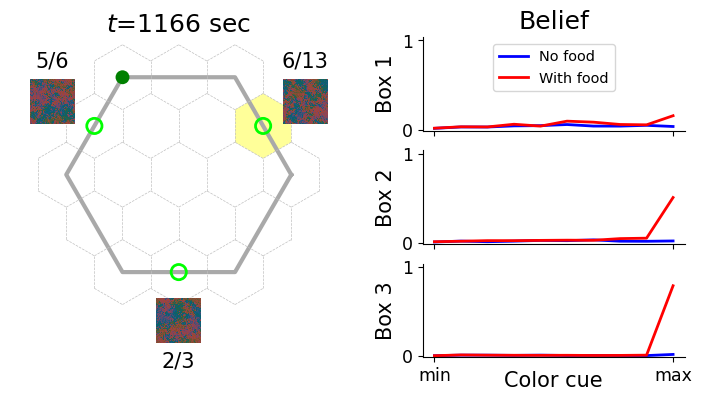

In [4]:
fig, ani = env.play_episode(
    pos, gaze, rewarded=rewarded, colors=colors, counts=counts, p_boxes=p_boxes, # tmin=env_data['num_steps']-240,
)

# HTML(ani.to_jshtml())
savename = f'belief.dynamics_{subject}_[{session_id}-{block_idx}]'
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'{savename}.svg')

## Belief compression

Beliefs are precomputed by sampling-based methods, and we train variational auto-encoder (VAE) to compress them into lower dimensional space.

In [5]:
seed, split = 0, 0.95
n = len(block_ids)
n_train = int(np.floor(n*split))
_idxs = np.random.default_rng(seed).choice(n, n, replace=False)
idxs = {'train': _idxs[:n_train], 'test': _idxs[n_train:]} # divide all blocks into train and test

ts_wait, observations, actions, knowns, beliefs = {}, {}, {}, {}, {}
for tag in ['train', 'test']:
    ts_wait[tag], observations[tag], actions[tag], knowns[tag], beliefs[tag] = [], [], [], [], []
    for i in tqdm(idxs[tag], desc=f"Preparing '{tag}'", unit='block', leave=False):
        session_id, block_idx = block_ids[i]
        _observations, _actions, _knowns, _beliefs = fetch_beliefs(subject, kappa, num_samples, session_id, block_idx)
        observations[tag].append(_observations[:-1])
        actions[tag].append(_actions)
        knowns[tag].append(_knowns[:-1])
        beliefs[tag].append(_beliefs[:-1])
        
        block_data = load_monkey_data(subject, session_id, block_idx)
        block_data = align_monkey_data(block_data)
        env_data = env.convert_experiment_data(block_data)
        ts_wait[tag].append(env_data['t_wait'][:-1])
    ts_wait[tag] = np.concatenate(ts_wait[tag])
    observations[tag] = np.concatenate(observations[tag])
    actions[tag] = np.concatenate(actions[tag])
    knowns[tag] = np.concatenate(knowns[tag])
    beliefs[tag] = torch.cat(beliefs[tag])

Preparing 'train':   0%|                                                                                      …

Preparing 'test':   0%|                                                                                       …

In [6]:
from hexarena.scripts.compress_beliefs import fetch_best_vae

z_dims = np.arange(1, 13)
kl_losses = {}
for z_dim in tqdm(z_dims, desc='Evaluating VAE', unit='dim'):
    _, belief_vae = fetch_best_vae(subject, kappa, num_samples, z_dim, cond={'seed': seed})
    with torch.no_grad():
        _, _, recons = belief_vae(beliefs['test'])
    _kl_losses, _ = zip(*[
        belief_vae.p_x.kl_divergence(beliefs['test'][i], recons[i])
        for i in range(len(recons))
    ])
    kl_losses[z_dim] = torch.stack(_kl_losses).numpy()

Evaluating VAE:   0%|                                                                                         …

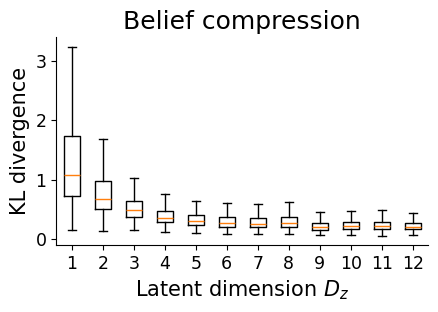

In [7]:
fig, ax = plt.subplots()
ax.boxplot(
    [kl_losses[z_dim] for z_dim in z_dims],
    sym='', positions=z_dims,
)
ax.set_xlabel('Latent dimension $D_z$')
ax.set_ylabel('KL divergence')
ax.set_title('Belief compression')
fig.savefig(FIG_DIR/f'belief.compression_{subject}_[kappa{kappa}].svg')

## Visualize belief in 3-D latent space

## Find a good rotation

In [8]:
z_dim, num_macros = 3, 10

_, belief_vae = fetch_best_vae(subject, kappa, num_samples, z_dim)
with torch.no_grad():
    zs, _ = belief_vae.encode(beliefs['train'])
zs = zs.numpy()
ts_boxes = np.log(ts_wait['train']+0.5)
ts_boxes += rng.normal(scale=0.0001, size=ts_boxes.shape) # break symmetry

In [9]:
proj_pth = STORE_DIR/f'belief.3D.proj_{subject}_[kappa{kappa}].pkl'
if os.path.exists(proj_pth):
    with open(proj_pth, 'rb') as f:
        w_rot = pickle.load(f)
    zs = np.matmul(zs, w_rot)
    zs_1d = zs[:, 0]
    zs_2d = zs[:, 1:]
else:
    w, *_ = np.linalg.lstsq(
        np.concatenate([zs, np.ones((len(zs), 1))], axis=1),
        ts_boxes.mean(axis=1), rcond=None,
    )
    w = w[:3]
    w /= (w**2).sum()**0.5
    zs_1d = np.matmul(zs, w)
    
    zs_res = zs-zs_1d[:, None]*w
    u, s, _ = np.linalg.svd(np.cov(zs_res.T), hermitian=True)
    zs_2d = np.matmul(zs_res, u[:, :2])
    
    w_rot = np.concatenate([w[:, None], u[:, :2]], axis=1)
    with open(proj_pth, 'wb') as f:
        pickle.dump(w_rot, f)

### Coloring by time since last push

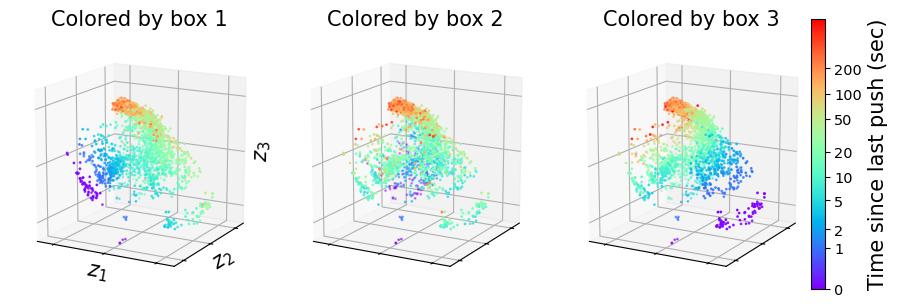

In [10]:
idxs = rng.choice(len(zs), 2000)
cmin, cmax = ts_boxes[idxs].min(), ts_boxes[idxs].max()

fig = plt.figure(figsize=(9, 3))
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/3
axes, artists = [], []
labelpad = -12
for i in range(3):
    ax = fig.add_axes([0.2*margin+(width+gap)*i, 0.02, width, 0.9], projection='3d', elev=15)
    artists.append(ax.scatter(
        zs[idxs, 1], zs[idxs, 2], zs[idxs, 0], s=1,
        c=ts_boxes[idxs, i], cmap='rainbow', vmin=cmin, vmax=cmax,
    ))
    ax_lim = [-4, 4]
    ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
    ax.set_aspect('equal')
    ax_ticks = [-3, 0, 3]
    ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
    ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
    ax.zaxis.line.set_visible(False)
    for line in ax.zaxis.get_majorticklines():
        line.set_color('none')
    if i==0:
        ax.set_xlabel('$z_1$', labelpad=labelpad)
        ax.set_ylabel('$z_2$', labelpad=labelpad)
        ax.set_zlabel('$z_3$', labelpad=labelpad)
    ax.set_title(f'Colored by box {i+1}', fontsize='medium')
    axes.append(ax)
cax = fig.add_axes([1-2*margin, margin, 0.3*margin, 1-2*margin])
cbar = plt.colorbar(artists[0], cax=cax, label='Time since last push (sec)')
ticks = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200])
cbar.ax.set_yticks(np.log(0.5+ticks/env.dt))
cbar.ax.set_yticklabels(['{:d}'.format(x) for x in ticks], fontsize='x-small')

def update(t, total=36):
    az = (t/total)*360-60
    for ax in axes:
        ax.view_init(azim=az)
    return artists

total = 360
ani = FuncAnimation(
    fig, update, fargs=(total,), frames=range(total), blit=True,
)

# HTML(ani.to_jshtml())
savename = f'colored.belief.space_{subject}_[kappa{kappa}]'
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200, fps=24)
fig.savefig(FIG_DIR/f'{savename}.svg')

### Trace in belief space

Block 1 of 20211213


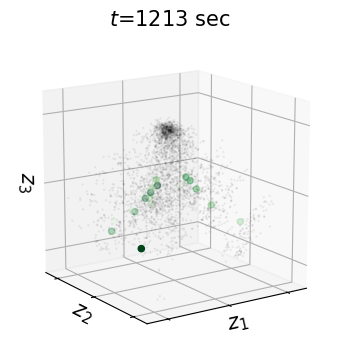

In [11]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_axes([0.05, 0.05, 0.9, 0.8], projection='3d', elev=15)
idxs = rng.choice(len(zs), 3000)
ax.scatter(zs[idxs, 1], zs[idxs, 2], zs[idxs, 0], s=0.5, c='black', alpha=0.05)
ax.set_xlim(ax_lim), ax.set_ylim(ax_lim), ax.set_zlim(ax_lim)
ax.set_aspect('equal')
ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks), ax.set_zticks(ax_ticks)
ax.set_xticklabels([]), ax.set_yticklabels([]), ax.set_zticklabels([])
ax.set_xlabel('$z_1$', labelpad=labelpad)
ax.set_ylabel('$z_2$', labelpad=labelpad)
ax.set_zlabel('$z_3$', labelpad=labelpad)
ax.zaxis.line.set_visible(False)
for line in ax.zaxis.get_majorticklines():
    line.set_color('none')

session_id, block_idx = block_ids[9]
print(f'Block {block_idx} of {session_id}')
*_, beliefs_block = fetch_beliefs(subject, kappa, num_samples, session_id, block_idx)
with torch.no_grad():
    zs_block, _ = belief_vae.encode(beliefs_block)
zs_block = np.matmul(zs_block.numpy(), w_rot)
trace_len = 20
h = ax.scatter(
    zs_block[:trace_len, 1], zs_block[:trace_len, 2], zs_block[:trace_len, 0],
    s=20, c=np.arange(trace_len), cmap='Greens',
)
h_title = ax.set_title('', fontsize='medium')

def update(t):
    az = 2*t-30
    ax.view_init(azim=az)
    h.set_offsets(zs_block[t-trace_len:t, 1:3])
    h.set_3d_properties(zs_block[t-trace_len:t, 0], 'z')
    h_title.set_text(r'$t$='+'{}'.format(
        '{:d} sec'.format(int(np.floor(t*env.dt)))
    ))
    return h, h_title

ani = FuncAnimation(
    fig, update, frames=range(trace_len, len(beliefs_block)), blit=True,
)

# HTML(ani.to_jshtml())
savename = f'belief.trace_{subject}_[{session_id}-{block_idx}]'
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200, fps=12)
fig.savefig(FIG_DIR/f'{savename}.svg')

## Visualize belief in 2-D space

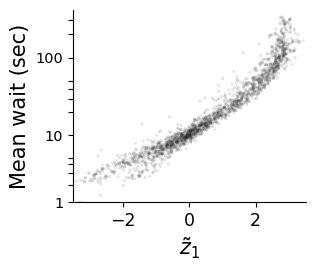

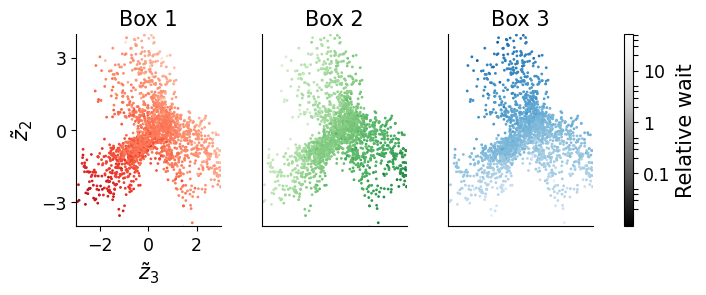

In [12]:
idxs = rng.choice(len(zs), 2000)
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.scatter(zs_1d[idxs], ts_boxes[idxs].mean(axis=1), s=5, edgecolor='none', facecolor='black', alpha=0.1)
ax.set_xlim([-3.5, 3.5])
ax.set_ylim([1, 6])
ax.set_xlabel(r'$\tilde{z}_1$')
ax.set_ylabel(r'Mean wait (sec)')
ticks = np.array([1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300])
ax.set_yticks(np.log(0.5+ticks/env.dt))
ax.set_yticklabels(['{:d}'.format(x) if x==10**int(np.log10(x)) else '' for x in ticks], fontsize='x-small')
fig.savefig(FIG_DIR/f'belief.1d_{subject}_[kappa{kappa}].svg')

cmaps = ['Reds_r', 'Greens_r', 'Blues_r']
dts = ts_boxes-ts_boxes.mean(axis=1, keepdims=True)
vmin, vmax = dts.min(), dts.max()
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))
for i, ax in enumerate(axes):
    ax.scatter(
        zs_2d[idxs, 1], zs_2d[idxs, 0], s=1,
        c=dts[idxs, i], cmap=cmaps[i], vmin=vmin, vmax=vmax
    )
    ax.set_xlim([-3, 3]), ax.set_ylim([-4, 4])
    ax.set_aspect('equal')
    ax.set_title(f'Box {i+1}', fontsize='medium')
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap='Greys_r'), ax=axes,
    fraction=0.1, label='Relative wait',
)
ticks = np.array([0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50])
cbar.ax.set_yticks(np.log(ticks))
cbar.ax.set_yticklabels(['{:g}'.format(x) if x==10**int(np.log10(x)) else '' for x in ticks], fontsize='small')
ax = axes[0]
ax.set_xticks([-2, 0, 2]), ax.set_yticks([-3, 0, 3])
ax.set_xlabel(r'$\tilde{z}_3$'), ax.set_ylabel(r'$\tilde{z}_2$')
for ax in axes[1:]:
    ax.set_xticks([]), ax.set_yticks([])
fig.savefig(FIG_DIR/f'belief.2d_{subject}_[kappa{kappa}].svg')